In [119]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

from collections import Counter

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append(os.path.abspath('..'))

from util import evaluate_model_performance, evaluate_model_fairness

In [120]:
data_path = Path(os.getcwd()).parent.parent / "data" / "dataset_diabetes"
df = pd.read_csv(data_path / "data_analyzed.csv")

In [121]:
df["age"] = df["age_all"]

# columns_to_remove = ['encounter_id', 'patient_nbr', 'readmitted', 'readmit_binary', 'diabetes_type', \
#     'had_emergency', 'had_inpatient_days', 'had_outpatient_days', 'race_all', 'age_all']

columns_to_remove = ['encounter_id', 'patient_nbr', 'readmitted', 'readmit_binary', 'diabetes_type', \
    'had_emergency', 'had_inpatient_days', 'had_outpatient_days', 'race_all', 'age_all',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', \
    'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', \
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' \
]

df_for_experimenting = df.drop(columns=columns_to_remove)

In [122]:
target_variable = "readmit_30_days"
sensitive = "race"

Y = df_for_experimenting.loc[:, target_variable]
A = df.loc[:, sensitive]
X = pd.get_dummies(df_for_experimenting.drop(columns=[target_variable])) #, sensitive]))

In [123]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_numeric,race_AfricanAmerican,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,3,59,0,18,0,0,0,9,10,0,...,1,0,0,0,1,0,1,0,0,1
2,2,11,5,13,2,0,1,6,20,1,...,1,0,0,0,1,0,0,1,0,1
3,2,44,1,16,0,0,0,7,30,0,...,1,0,0,0,1,0,1,0,0,1
4,1,51,0,8,0,0,0,5,40,0,...,1,0,0,0,1,0,1,0,0,1


In [124]:
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

### Undersampling

In [125]:
def resample_dataset(X_train, Y_train): #, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  # A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train #, A_train

In [126]:
X_train_bal, Y_train_bal = resample_dataset(X_train, Y_train) #, A_train)

In [127]:
print(f'Resampled dataset samples per class {Counter(Y_train_bal)}')

Resampled dataset samples per class Counter({False: 5678, True: 5678})


### Logistic regression

In [128]:
lr_res = LogisticRegression(solver='newton-cg')
lr_res.fit(X_train_bal, Y_train_bal)

# Predicting on the test data
lr_pred_test_res = lr_res.predict(X_test)
evaluate_model_performance(Y_test, lr_pred_test_res)
evaluate_model_fairness(Y_test, lr_pred_test_res, A_test)

The accuracy score for the testing data: 0.6383789945363783
The precision score for the testing data: 0.16319830553349218
The recall score for the testing data: 0.5427011797851734
The F1 score for the testing data: 0.250936329588015
The F2 score for the testing data: 0.37042378788971425
The specificity score for the testing data: 0.6503993097803243
The balanced accuracy score for the testing data: 0.5965502447827489
The G mean score for the testing data: 0.5941148649455292
[[29400 15803]
 [ 2597  3082]]
The Demographic parity difference score for the testing data: 0.2247431448863099
The Equalized odds difference score for the testing data: 0.31965167216560475
The Equal opportunity difference score for the testing data: 0.5427011797851734


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

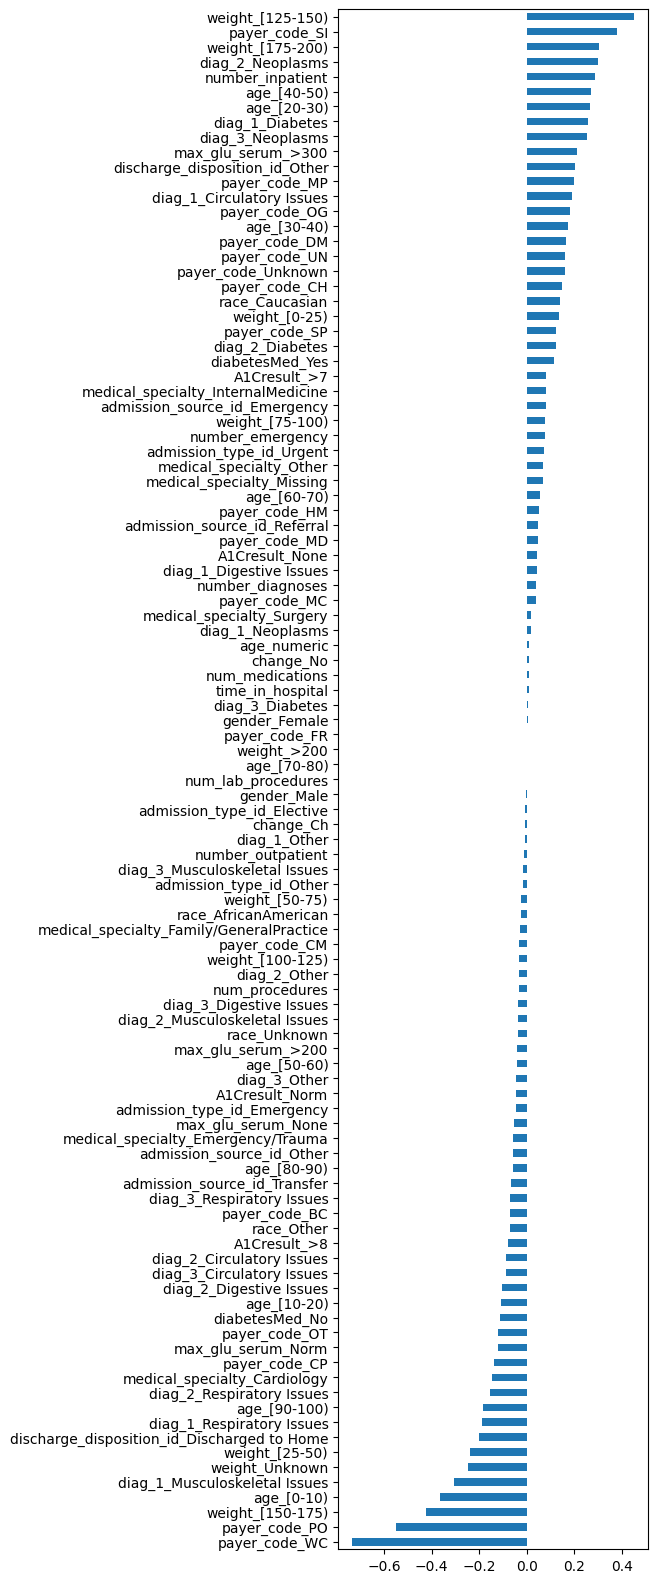

In [129]:
coef_series = pd.Series(data=lr_res.coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 20), legend=False)

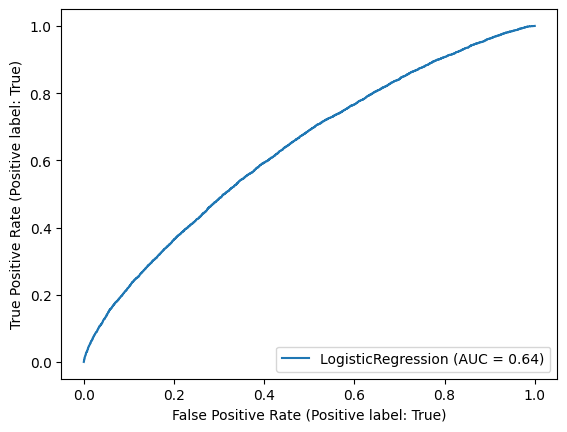

In [130]:
metrics.RocCurveDisplay.from_estimator(lr_res, X_test, Y_test)

### Decision tree

In [139]:
# tree_auto_balanced_res = DecisionTreeClassifier()
# tree_auto_balanced_res = DecisionTreeClassifier(max_depth=17)
# tree_auto_balanced_res = DecisionTreeClassifier(criterion='gini', max_depth=28)
tree_auto_balanced_res = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree_auto_balanced_res.fit(X_train_bal, Y_train_bal)

# Predicting on the test data
tree_pred_test_res = tree_auto_balanced_res.predict(X_test)
evaluate_model_performance(Y_test, tree_pred_test_res)
evaluate_model_fairness(Y_test, tree_pred_test_res, A_test)

The accuracy score for the testing data: 0.6353916905782006
The precision score for the testing data: 0.15515671042057327
The recall score for the testing data: 0.5099489346715971
The F1 score for the testing data: 0.23792310220177454
The F2 score for the testing data: 0.3499190449723303
The specificity score for the testing data: 0.6511514722474172
The balanced accuracy score for the testing data: 0.5805502034595071
The G mean score for the testing data: 0.576241268551995
[[29434 15769]
 [ 2783  2896]]
The Demographic parity difference score for the testing data: 0.09819080134283426
The Equalized odds difference score for the testing data: 0.10916192141150077
The Equal opportunity difference score for the testing data: 0.5099489346715971


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
params =  {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(10,30)   
}

# scoring = ['recall', 'balanced_accuracy']

dtc = DecisionTreeClassifier(random_state=123)

grid_search = GridSearchCV(estimator=dtc,
                    param_grid=params,
                    scoring='recall')

grid_search.fit(X_train_bal, Y_train_bal)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(10, 30)},
             scoring='recall')

In [133]:
grid_search.best_score_, grid_search.best_params_

(0.5773132406775454, {'criterion': 'gini', 'max_depth': 28})

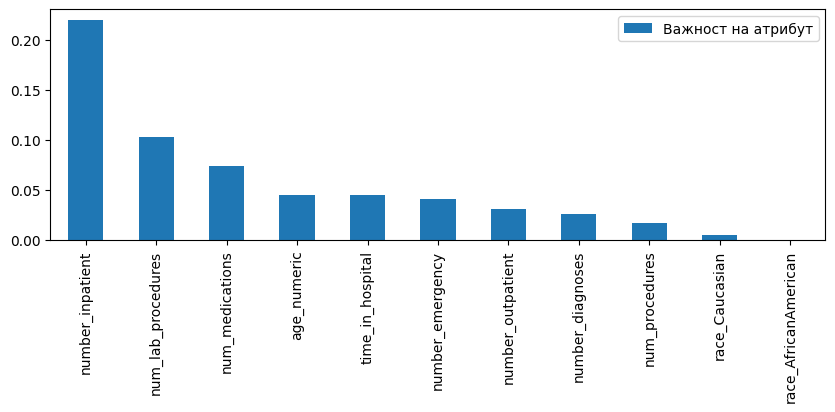

In [140]:
fig, ax = plt.subplots()

feat_importances = pd.DataFrame(tree_auto_balanced_res.feature_importances_[:11], index=X_train_bal.columns[:11], columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(10,3), ax=ax)
#ax = df.plot(kind='bar') # "same" as above
ax.legend(["Важност на атрибут"])

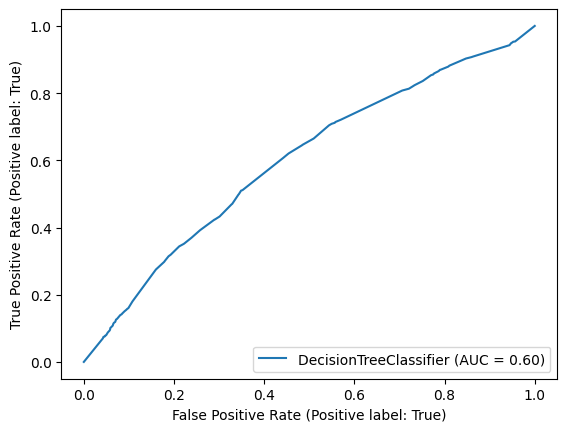

In [141]:
metrics.RocCurveDisplay.from_estimator(tree_auto_balanced_res, X_test, Y_test)

### Perceptron

In [79]:
perceptron_res = Perceptron()
perceptron_res.fit(X_train_bal, Y_train_bal)

# Predicting on the test data
perceptron_pred_test_res = perceptron_res.predict(X_test)
evaluate_model_performance(Y_test, perceptron_pred_test_res)
evaluate_model_fairness(Y_test, perceptron_pred_test_res, A_test)

The accuracy score for the testing data: 0.34269486262332455
The precision score for the testing data: 0.1315747571784937
The recall score for the testing data: 0.8730410283500616
The F1 score for the testing data: 0.22868476280528585
The F2 score for the testing data: 0.41044405443888876
The specificity score for the testing data: 0.2760657478485941
The balanced accuracy score for the testing data: 0.5745533880993279
The G mean score for the testing data: 0.4909345418627267
[[12479 32724]
 [  721  4958]]
The Demographic parity difference score for the testing data: 0.08607383152970227
The Equalized odds difference score for the testing data: 0.08850517149037684
The Equal opportunity difference score for the testing data: 0.8730410283500616


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM (linear kernel)

In [80]:
svm_res = LinearSVC()
svm_res.fit(X_train_bal, Y_train_bal)

# Predicting on the test data
svm_pred_test_res = svm_res.predict(X_test)
evaluate_model_performance(Y_test, svm_pred_test_res)
evaluate_model_fairness(Y_test, svm_pred_test_res, A_test)

c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The accuracy score for the testing data: 0.1288667898274439
The precision score for the testing data: 0.11326154831478664
The recall score for the testing data: 0.996478253213594
The F1 score for the testing data: 0.20340384235213774
The F2 score for the testing data: 0.3893093010456797
The specificity score for the testing data: 0.019865938101453443
The balanced accuracy score for the testing data: 0.5081720956575237
The G mean score for the testing data: 0.14069817091130116
[[  898 44305]
 [   20  5659]]
The Demographic parity difference score for the testing data: 0.013253478722929146
The Equalized odds difference score for the testing data: 0.014928571057854723
The Equal opportunity difference score for the testing data: 0.996478253213594


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gaussian Naive Bayes

In [81]:
nbc = GaussianNB()
nbc.fit(X_train_bal, Y_train_bal)

# Predicting on the test data
nbc_pred_test_res = nbc.predict(X_test)
evaluate_model_performance(Y_test, nbc_pred_test_res)
evaluate_model_fairness(Y_test, nbc_pred_test_res, A_test)

The accuracy score for the testing data: 0.7743013246334657
The precision score for the testing data: 0.16024815638534473
The recall score for the testing data: 0.24106356752949462
The F1 score for the testing data: 0.19251863310364223
The F2 score for the testing data: 0.21897693464282286
The specificity score for the testing data: 0.8412937194433998
The balanced accuracy score for the testing data: 0.5411786434864472
The G mean score for the testing data: 0.45033905598913326
[[38029  7174]
 [ 4310  1369]]
The Demographic parity difference score for the testing data: 0.05777179994579168
The Equalized odds difference score for the testing data: 0.1094498754073222
The Equal opportunity difference score for the testing data: 0.24106356752949462


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### t-SNE visualization

In [82]:
tsne_embedding = TSNE(n_components=2, learning_rate=50, init='random', perplexity=50).fit_transform(pd.get_dummies(X))

NameError: name 'TSNE' is not defined

In [ ]:
tsne_embedding_oversampled_smotenc = TSNE(n_components=2, learning_rate=50, init='random', perplexity=50).fit_transform(X_res)

In [ ]:
colors = ['#F3DC1B', '#F37A3F', '#EC1DF3', '#27C4F1', '#00F37A', "red", "blue", "purple", 'green', 'yellow', 'pink', 'cyan', 'magenta', 'orange', 'grey', 'black']

sns.set()
_, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.scatterplot(
    ax=axes[0],
    x=tsne_embedding[:, 0], y=tsne_embedding[:, 1],
    hue=list(Y),
    data=tsne_embedding,
    legend="full",
    alpha=0.2,
    palette=colors
)

sns.scatterplot(
    ax=axes[1],
    x=tsne_embedding_oversampled_smotenc[:, 0], y=tsne_embedding_oversampled_smotenc[:, 1],
    hue=list(Y_res),
    data=tsne_embedding_oversampled_smotenc,
    legend="full",
    alpha=0.2,
    palette=colors
)

### UMAP

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding_umap = reducer.fit_transform(pd.get_dummies(X))

In [ ]:
embedding_umap_resampled = reducer.fit_transform(X_res)

In [ ]:
sns.set()
_, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.scatterplot(
    ax=axes[0],
    x=embedding_umap[:, 0], y=embedding_umap[:, 1],
    hue=list(Y),
    data=embedding_umap,
    legend="full",
    alpha=0.2
)

sns.scatterplot(
    ax=axes[1],
    x=embedding_umap_resampled[:, 0], y=embedding_umap_resampled[:, 1],
    hue=list(Y_res),
    data=embedding_umap_resampled,
    legend="full",
    alpha=0.2
)

### PCA - 2d

In [ ]:
pca = PCA(n_components=2, whiten=True) 
X_pca = pca.fit_transform(pd.get_dummies(X))
X_resampled_pca = pca.fit_transform(X_res)

In [ ]:
sns.set()
_, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.scatterplot(
    ax=axes[0],
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=list(Y),
    data=X_pca,
    legend="full",
    alpha=0.2
)

sns.scatterplot(
    ax=axes[1],
    x=X_resampled_pca[:, 0], y=X_resampled_pca[:, 1],
    hue=list(Y_res),
    data=X_resampled_pca,
    legend="full",
    alpha=0.2
)

### PCA - 3d

In [ ]:
pca = PCA(n_components=3, whiten=True) 
X_pca_3d = pca.fit_transform(pd.get_dummies(X))
X_resampled_pca_3d = pca.fit_transform(X_res)

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2])
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

### Hypertools (should be cited)

In [ ]:
X_reduced = hyp.reduce(x=X, reduce='IncrementalPCA', ndims=10)

In [ ]:
X_tsne_double_reduced = hyp.reduce(x=X_reduced, reduce='TSNE', ndims=3)

In [ ]:
hyp.plot(X_tsne_double_reduced, '.', hue=Y, save_path='.')

In [ ]:
hyp.plot(X_res, '.', hue=Y_res, reduce='FastICA')